In [1]:
import numpy as np
import pandas as pd
import gc
import os
import sys
import yaml
import re
import random
import math
import matplotlib.pyplot as plt
import warnings
import pickle
from tqdm.notebook import tqdm
from typing import *
from pathlib import Path
from dataclasses import dataclass, field, asdict
from shutil import copyfile
from cuml.neighbors import NearestNeighbors
warnings.simplefilter('ignore')

In [2]:
@dataclass
class Config:
    outdir: str = "../results/efficientnet-tpu"
    device: str = "cuda:0"
    device_id: int = 0

    datadir: str = '../data/tfrecord-gkf'
    image_dir: str = '../data/shopee-product-matching/train_images'
    seed: int = 42
    n_splits: int = 1
    tf_expt: int = -1
    image_size: List[int] = field(default_factory=lambda: [512, 512])
    emb_len: int = 2048

    # Training config
    batch_size: int = 20
    epochs: int = 100
    patience: int = 5
    lr: float = 0.00001

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [4]:
config = Config()
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.device_id)

base_dir = Path().resolve()
sys.path.append(os.path.abspath(base_dir / '../'))

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

from src.tokenization import *
from src.preprocess import *
from src.image import *
from src.model import *

In [5]:
# Function to get our f1 score
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1


def precision_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    return intersection / len_y_pred


def recall_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_true = y_true.apply(lambda x: len(x)).values
    return intersection / len_y_true

In [6]:
# Function to read our test image and return image
def read_image(image, image_size):
    image = tf.io.read_file(image)
    image = decode_image(image, image_size)
    return image


# Function to get our dataset that read images
def get_dataset(image, config):
    dataset = tf.data.Dataset.from_tensor_slices(image)
    dataset = dataset.map(lambda x: read_image(x, config.image_size), num_parallel_calls = config.tf_expt)
    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(config.tf_expt)
    return dataset

In [7]:
train = pd.read_csv(base_dir / config.datadir / 'train_folds.csv')
train.head()

,posting_id,image,image_phash,title,label_group,matches,f1,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,0,train_129225211 train_2278313361,0.666667,0
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",1,train_3386243561 train_3423213080,0.666667,3
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,1,train_2288590299 train_3803689425,0.666667,0
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,3,train_2406599165 train_3342059966,0.666667,2
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,4,train_3369186413 train_921438619,0.666667,2


In [8]:
def get_embeddings(df: pd.DataFrame, weight_path: Path, en_type: str, n_classes: int):
    image_paths = [str(base_dir / config.image_dir / filename) for filename in df['image']]
    
    model = build_efficientnet_model(
        n_classes=n_classes,
        image_size=config.image_size,
        lr=config.lr,
        en_type=en_type,
        train=False,
        emb_len=config.emb_len
    )
    model.load_weights(str(weight_path))
    model1 = tf.keras.models.Model(inputs=model.input[0:3], outputs=model.layers[-4].output)
    arc_W = model.layers[-2].W
    get_cosine = lambda X: tf.matmul(tf.math.l2_normalize(X, axis=1), tf.math.l2_normalize(arc_W, axis=0)).numpy()
    
    del model
    gc.collect()
    
    chunk = 500
    iterator = np.arange(np.ceil(len(df) / chunk))

    embeds = []
    cosines = []
    for j in tqdm(iterator):
        a = int(j * chunk)
        b = int((j + 1) * chunk)

        image_dataset = get_dataset(image_paths[a:b], config)
        embeddings = model1.predict(image_dataset)
        cosine = get_cosine(embeddings)
        
        embeds.append(embeddings)
        cosines.append(cosine)
    
    del model1
    gc.collect()
    tf.keras.backend.clear_session()
    return np.concatenate(embeds), np.concatenate(cosines)

In [9]:
def get_valid_df(fold: int):
    return train.query(f'fold != {fold}')

In [10]:
def get_embeddings_list(epoch: int, en_type: str, n_classes: int):
    epoch = format(epoch, '02')
    embeddings_list = list()
    
    for i in range(config.n_splits):
        outdir = base_dir / config.outdir / f'EfficientNet{en_type}_GKF_seed{config.seed}_fold{i}_emb{config.emb_len}'
        weight_path = outdir / f'epoch{epoch}.h5'
        emb_outpath = outdir / f'embeddings_epoch{epoch}.pkl'

        if os.path.exists(emb_outpath):
            print('get embeddings and cosines from the cashe')
            embeddings = pickle.load(open(str(emb_outpath), 'rb'))

        else:
            embeddings, cosines = get_embeddings(
                df=train,
                weight_path=weight_path,
                en_type=en_type,
                n_classes=n_classes
            )
            pickle.dump(
                embeddings,
                open(str(emb_outpath), 'wb')
            )
            
        embeddings_list += [embeddings]
                
    return embeddings_list

In [11]:
def get_matches(df: pd.DataFrame, distance: np.ndarray, indice: np.ndarray, thr: float) -> List[str]:
    idx = np.where(distance < thr)[0]
    ids = indice[idx]
    return df['posting_id'].iloc[ids].values.tolist()
    
    
def search_thresholds(df: pd.DataFrame, embeddings: np.ndarray, fold: int, knn: int = 50, metric='euclidean', 
                      thr_start: int = 3, thr_end: int = 5, thr_interval: float = 0.1, same_cls: bool = True):
    valid_df = train.query(f'fold != {fold}')
    valid_embeddings = embeddings[valid_df.index, :]
    # KNN
    knn_model = NearestNeighbors(n_neighbors=knn, metric=metric)
    knn_model.fit(valid_embeddings)
    
    distances, indices = knn_model.kneighbors(valid_embeddings)

    # grid search
    thresholds = list(np.arange(thr_start, thr_end, thr_interval))
    scores = []
    for threshold in thresholds:
        predictions = []
        for k in range(valid_embeddings.shape[0]):
            matches = get_matches(df=valid_df, distance=distances[k, ], indice=indices[k, ], thr=threshold)
            posting_ids = ' '.join(matches)
            predictions.append(posting_ids)
        valid_df['pred_matches'] = predictions
        valid_df['f1'] = f1_score(valid_df['matches'], valid_df['pred_matches'])
        score = valid_df['f1'].mean()
        print(f'Our f1 score for threshold {np.round(threshold, 2)} is {score}')
        scores.append(score)
    thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})

    max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
    best_threshold = max_score['thresholds'].values[0]
    best_score = max_score['scores'].values[0]
    print(f'Our best score is {best_score} and has a threshold {best_threshold}')
    
    del knn_model, valid_embeddings, distances, indices
    gc.collect()
    
    return best_score, best_threshold, thresholds_scores


def database_augment(embeddings, n_aug):
    weights = np.logspace(0, -1.5, n_aug)
    model = NearestNeighbors(n_neighbors=n_aug, metric='cosine')
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    dba_embeddings = list()
    for k in range(embeddings.shape[0]):
        neighbor_embeddings = embeddings[indices[k, ]]
        comb = np.dot(weights, neighbor_embeddings)
        dba_embeddings.append(comb)
    dba_embeddings = np.vstack(dba_embeddings)
    
    del model, distances, indices
    gc.collect()
    return dba_embeddings

In [24]:
en_type = 'B0'
fold = 0
historyb0 = pickle.load(open(
    base_dir / config.outdir / f'EfficientNetB0_GKF_seed{config.seed}_fold{fold}_emb{config.emb_len}' / 'history.pkl', 
    'rb'))
historyb3 = pickle.load(open(
    base_dir / config.outdir / f'EfficientNetB3_GKF_seed{config.seed}_fold{fold}_emb{config.emb_len}' / 'history.pkl', 
    'rb'))
historyb5 = pickle.load(open(
    base_dir / config.outdir / f'EfficientNetB5_GKF_seed{config.seed}_fold{fold}_emb{config.emb_len}' / 'history.pkl', 
    'rb'))

In [16]:
n_classes = train.query(f'fold == {fold}').label_group.unique().shape[0]

In [18]:
en_type = 'B0'
embeddingsb0 = get_embeddings_list(epoch=20, en_type=en_type, n_classes=n_classes)[0]
_, _, scoresb0 = search_thresholds(train, embeddingsb0, 0, 50, 'cosine', 0, 1, 0.1)
dba_embeddingsb0 = database_augment(embeddingsb0, n_aug=3)
_, _, dba_scoresb0 = search_thresholds(train, dba_embeddingsb0, 0, 50, 'cosine', 0, 1, 0.1)

get embeddings and cosines from the cashe
Our f1 score for threshold 0.0 is 0.20856544815567327
Our f1 score for threshold 0.1 is 0.627941310041503
Our f1 score for threshold 0.2 is 0.6724243761407896
Our f1 score for threshold 0.3 is 0.7042371212307542
Our f1 score for threshold 0.4 is 0.7229675701347901
Our f1 score for threshold 0.5 is 0.6960564983298336
Our f1 score for threshold 0.6 is 0.5263405070525186
Our f1 score for threshold 0.7 is 0.2080702630617587
Our f1 score for threshold 0.8 is 0.16031574386063532
Our f1 score for threshold 0.9 is 0.16031562688088405
Our best score is 0.7229675701347901 and has a threshold 0.4
Our f1 score for threshold 0.0 is 0.20857540130166702
Our f1 score for threshold 0.1 is 0.6557026850409182
Our f1 score for threshold 0.2 is 0.7087834433226491
Our f1 score for threshold 0.3 is 0.7382156534798772
Our f1 score for threshold 0.4 is 0.7306942297583153
Our f1 score for threshold 0.5 is 0.6610400711662727
Our f1 score for threshold 0.6 is 0.4690004632

In [19]:
en_type = 'B3'
embeddingsb3 = get_embeddings_list(epoch=20, en_type=en_type, n_classes=n_classes)[0]
_, _, scoresb3 = search_thresholds(train, embeddingsb3, 0, 50, 'cosine', 0, 1, 0.1)
dba_embeddingsb3 = database_augment(embeddingsb3, n_aug=3)
_, _, dba_scoresb3 = search_thresholds(train, dba_embeddingsb3, 0, 50, 'cosine', 0, 1, 0.1)

get embeddings and cosines from the cashe
Our f1 score for threshold 0.0 is 0.2116099907574869
Our f1 score for threshold 0.1 is 0.6373048667281968
Our f1 score for threshold 0.2 is 0.6807889644418782
Our f1 score for threshold 0.3 is 0.7112571563788362
Our f1 score for threshold 0.4 is 0.7235001952892217
Our f1 score for threshold 0.5 is 0.6746450266033281
Our f1 score for threshold 0.6 is 0.48452713284889015
Our f1 score for threshold 0.7 is 0.1992404784841083
Our f1 score for threshold 0.8 is 0.16147446853476627
Our f1 score for threshold 0.9 is 0.16147446853476627
Our best score is 0.7235001952892217 and has a threshold 0.4
Our f1 score for threshold 0.0 is 0.21317578867545636
Our f1 score for threshold 0.1 is 0.6652786180285001
Our f1 score for threshold 0.2 is 0.7166155497440825
Our f1 score for threshold 0.3 is 0.740936342569165
Our f1 score for threshold 0.4 is 0.7225053807049848
Our f1 score for threshold 0.5 is 0.6365756207256044
Our f1 score for threshold 0.6 is 0.4315927351

In [20]:
en_type = 'B5'
embeddingsb5 = get_embeddings_list(epoch=20, en_type=en_type, n_classes=n_classes)[0]
_, _, scoresb5 = search_thresholds(train, embeddingsb5, 0, 50, 'cosine', 0, 1, 0.1)
dba_embeddingsb5 = database_augment(embeddingsb5, n_aug=3)
_, _, dba_scoresb5 = search_thresholds(train, dba_embeddingsb5, 0, 50, 'cosine', 0, 1, 0.1)

get embeddings and cosines from the cashe
Our f1 score for threshold 0.0 is 0.21110822814771335
Our f1 score for threshold 0.1 is 0.6416734103679534
Our f1 score for threshold 0.2 is 0.6839369649694947
Our f1 score for threshold 0.3 is 0.7118180358940576
Our f1 score for threshold 0.4 is 0.7211070318430641
Our f1 score for threshold 0.5 is 0.6780555115559282
Our f1 score for threshold 0.6 is 0.5029110288248978
Our f1 score for threshold 0.7 is 0.21535052246966
Our f1 score for threshold 0.8 is 0.16252132853550533
Our f1 score for threshold 0.9 is 0.16252113498718962
Our best score is 0.7211070318430641 and has a threshold 0.4
Our f1 score for threshold 0.0 is 0.21244457383061385
Our f1 score for threshold 0.1 is 0.6691289019828252
Our f1 score for threshold 0.2 is 0.7181328714386596
Our f1 score for threshold 0.3 is 0.7410016452311067
Our f1 score for threshold 0.4 is 0.721617674652501
Our f1 score for threshold 0.5 is 0.6428066692385365
Our f1 score for threshold 0.6 is 0.452331348486

In [26]:
historyb0.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

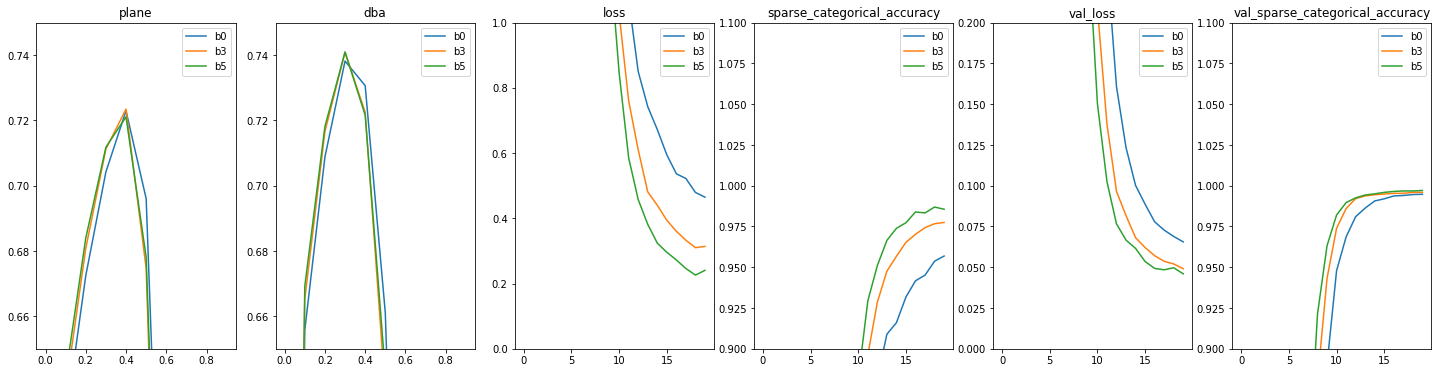

In [44]:
fig, axes = plt.subplots(1, 6, figsize=(25, 6))
for b0, b3, b5, ax, title in zip(
    [scoresb0, dba_scoresb0], 
    [scoresb3, dba_scoresb3], 
    [scoresb5, dba_scoresb5], 
    axes[:2],
    ['plane', 'dba']
):
    ax.plot(b0.thresholds, b0.scores, label='b0')
    ax.plot(b3.thresholds, b3.scores, label='b3')
    ax.plot(b5.thresholds, b5.scores, label='b5')
    ax.set_title(title)
    ax.set_ylim(0.65, 0.75)
    ax.legend()
    
for i, (ax, title, rng) in enumerate(zip(
    axes[2:], 
    ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'],
    [(0, 1), (0.9, 1.1), (0, 0.2), (0.9, 1.1)]
)):
    ax.plot(historyb0[title], label='b0')
    ax.plot(historyb3[title], label='b3')
    ax.plot(historyb5[title], label='b5')
    ax.set_title(title)
    ax.set_ylim(rng)
    ax.legend()
plt.show()

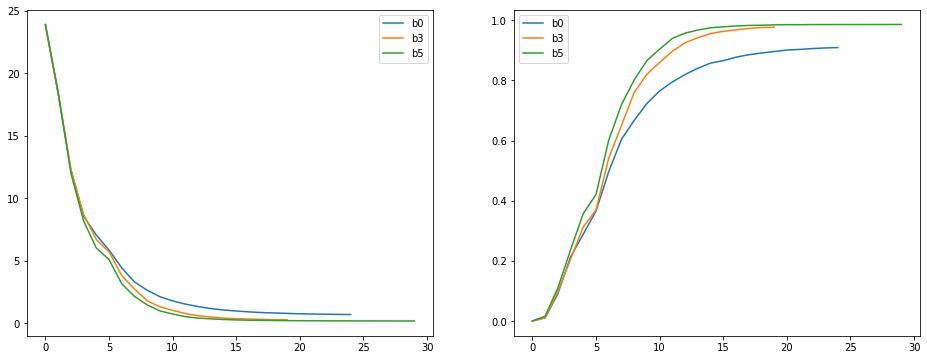

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for postfix in ['b0', 'b3', 'b5']:
    history = pickle.load(open(base_dir / config.outdir / f'history{postfix}.pkl', 'rb'))
    axes[0].plot(history['val_loss'], label=postfix)
    axes[0].legend()
    axes[1].plot(history['val_sparse_categorical_accuracy'], label=postfix)
    axes[1].legend()
plt.show()

In [15]:
# epoch 20, original emb length
embeddings = pickle.load(open(
    base_dir / config.outdir / 'EfficientNetB3_GKF_seed42_fold0' / 'embeddings_epoch20.pkl',
    'rb'
))
search_thresholds(train, embeddings, 0, 50, 'cosine', 0, 1, 0.1)

Our f1 score for threshold 0.0 is 0.21136501056874615
Our f1 score for threshold 0.1 is 0.6318436088035322
Our f1 score for threshold 0.2 is 0.6732567539655672
Our f1 score for threshold 0.3 is 0.7052853458667269
Our f1 score for threshold 0.4 is 0.7236437799205924
Our f1 score for threshold 0.5 is 0.7020545829531672
Our f1 score for threshold 0.6 is 0.5675567797880232
Our f1 score for threshold 0.7 is 0.2668932268081943
Our f1 score for threshold 0.8 is 0.16249199899616787
Our f1 score for threshold 0.9 is 0.16244502206718642
Our best score is 0.7236437799205924 and has a threshold 0.4


(0.7236437799205924, 0.4)

In [18]:
dba_embeddings = database_augment(embeddings, n_aug=3)
search_thresholds(train, dba_embeddings, 0, 50, 'cosine', 0, 1, 0.1)

Our f1 score for threshold 0.0 is 0.21248453574956677
Our f1 score for threshold 0.1 is 0.6887800339608241
Our f1 score for threshold 0.2 is 0.7381979034440679
Our f1 score for threshold 0.3 is 0.741598896607282
Our f1 score for threshold 0.4 is 0.7081099215317337
Our f1 score for threshold 0.5 is 0.625942343253889
Our f1 score for threshold 0.6 is 0.45095603715176513
Our f1 score for threshold 0.7 is 0.21611419373766388
Our f1 score for threshold 0.8 is 0.164078589608325
Our f1 score for threshold 0.9 is 0.16407179863335883
Our best score is 0.741598896607282 and has a threshold 0.30000000000000004


(0.741598896607282, 0.30000000000000004)